# Introduction

This notebook shows how features can be created using the TDA (topological data analysis) library giotto-learn. The dataset that is used comes from the Kaggle competition "Predicting Molecular Properties -
Can you measure the magnetic interactions between a pair of atoms?" (https://www.kaggle.com/c/champs-scalar-coupling/overview). The goal is therefore to ....


Inspiration for the creation of non-TDA features was taken from https://www.kaggle.com/robertburbidge/distance-features. For the molecule visualization the following notebook served as a template: https://www.kaggle.com/mykolazotko/3d-visualization-of-molecules-with-plotly.

# Imports

In [26]:
# Libraries import
# General imports
from itertools import product
import os, random, sys

sys.path.append('../code/')
sys.path.append('../src/')



# Import for data handling
import numpy as np
import pandas as pd
import networkx as nx
import pickle
from data.dataset_utils import get_selected_structures

# Machine Learning imports
from giotto.homology import VietorisRipsPersistence
from models.model import cv_model
import giotto.diagrams as diag

# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
from visualization.molecule_plotting import plot_molecule
from visualization.plotting import plot_diagram, plot_betti_curves
import giotto.diagrams as diag
from features.dataset_creation import *
from features.dataset_creation import *
from features.new_features import *
from features.features import *
from plotly.offline import init_notebook_mode, iplot

# Other
import warnings
warnings.filterwarnings("ignore")

# Dataset Loading and Analysis

In [20]:
# Data import
file_folder = '../data/raw'
train = pd.read_csv(f'{file_folder}/train.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')

For ths demo we focus on the 100 largest molecules and their 12609 edges from the training dataset. There are 8 different bond types: 1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN. The plot below shows the different bond strengths related to the different types. For the 100 largest molecules only the five bond types 1JHC, 2JHC, 3JHC, 2JHH, 3JHH are available.

In [21]:
# top 100 molecules with the most number of atoms
def get_number_of_atoms(g):
    return len(g)
molecule_selection = train.groupby(by='molecule_name').apply(get_number_of_atoms).nlargest(100).index 

selection = train[train['molecule_name'].isin(molecule_selection)].reset_index()
molecules = selection['molecule_name'].values

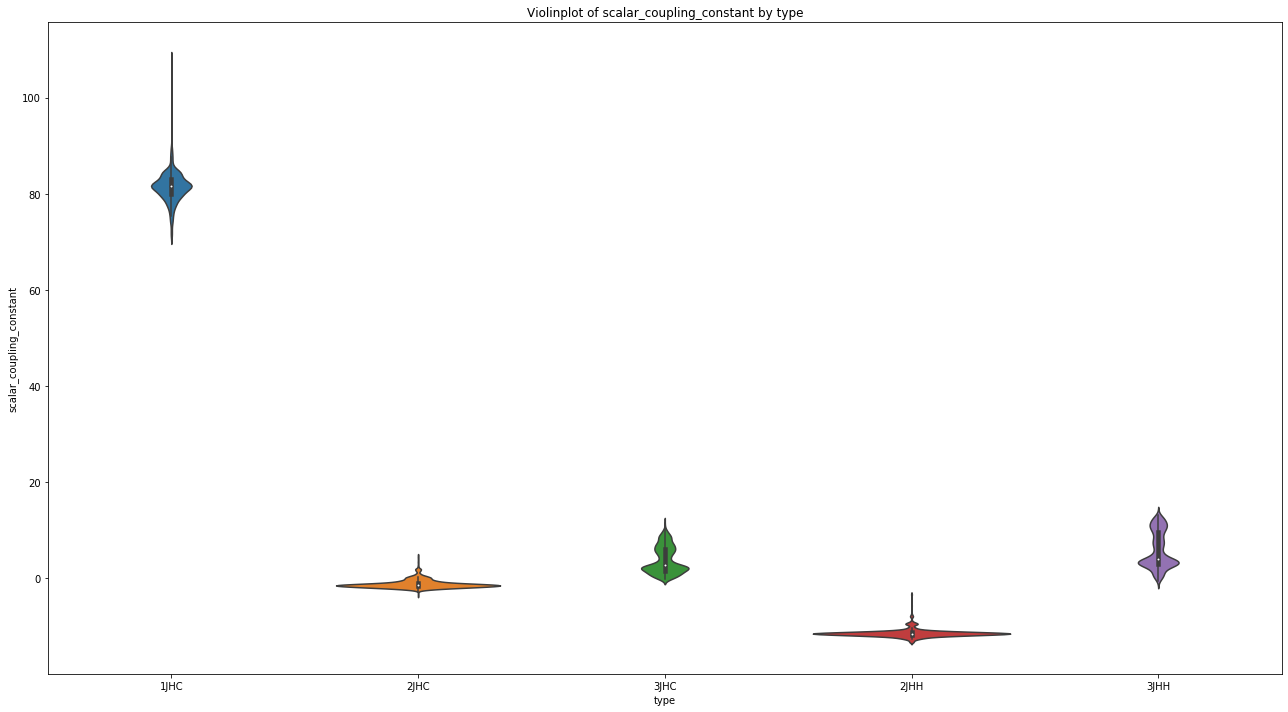

In [22]:
fig, ax = plt.subplots(figsize = (18, 10))
sns.violinplot(x='type', y='scalar_coupling_constant', data=selection)
plt.title('Violinplot of scalar_coupling_constant by type')
fig.tight_layout()

# Feature Creation and Visulization

## Non-TDA

In this notebook we show how features generated using topological data analysis (TDA) can be used to improve your machine learning models. Nevertheless, we will also use some non-TDA features. Here we give a brief overview of which features were used. Credit goes to this notebook, where the features were presented: https://www.kaggle.com/robertburbidge/distance-features. The focus here lies on a geometric analysis, hence the name 'distance features'. 

List of non-TDA features (atom 0 or 1 respectively refers to the atoms in the atom pair that makes up the bond):

* 'atom_index_0', 'atom_index_1'
* 'type', 'type_0', 'type_1'
* 'atom_0', 'atom_1'
* 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'
* 'dist', 'dist_x', 'dist_y', 'dist_z', 
* 'dist_0tomean', 'dist_0tomeanH', 'dist_0tomeanC', 'dist_0tomeanN', 'dist_to_type_0_mean', 
* 'dist_1tomeanC', 'dist_1tomeanH', 'dist_1tomeanN', 
* 'dist_0l', 'dist_0r', 'dist_1l', 'dist_1r'
* 'dist_to_type_mean', 'dist_to_type_1_mean', 'dist_1tomean'
* 'molecule_dist_mean_x', 'molecule_dist_std_x', 'molecule_dist_mean_y', 'molecule_dist_std_y'
* 'molecule_dist_skew_x', 'molecule_dist_kurt_x', 'molecule_dist_skew_y', 'molecule_dist_kurt_y'
* 'meanxH', 'meanyH', 'meanzH', 'meanxC','meanyC', 'meanzC', 'meanxN', 'meanyN', 'meanzN'
* 'meanx', 'meany', 'meanz', 'meanxO', 'meanyO', 'meanzO', 'meanxF', 'meanyF', 'meanzF'
* 'dist_0tomeanO', 'dist_1tomeanO', 'dist_0tomeanF', 'dist_1tomeanF'
* 'x_1r', 'y_1r', 'z_1r', 'x_0l', 'y_0l', 'z_0l', 'x_0r', 'y_0r', 'z_0r', 'x_1l', 'y_1l', 'z_1l'
* 'atom_count', 'atom_0l', 'atom_0r', 'atom_1l', 'atom_1r'

As the creation of these features takes a while, we import them directly from a CSV file. In case you want to recreate the data on your own, you can either have a look at the notebook linked above or use the 'Distance_feature.py' script in this repository.

In [4]:
# Import classical features
train_dist = pd.read_csv('../data/processed/train_dist.csv')

X = train_dist[train_dist['molecule_name'].isin(molecule_selection)].reset_index()
y = X['scalar_coupling_constant']
molecules = X['molecule_name'].values
X.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis='columns', inplace=True)


lenc = LabelEncoder()
lenc.fit(X['atom_1'])
X['atom_0'] = lenc.transform(X['atom_0'])
X['atom_1'] = lenc.transform(X['atom_1'])

X.drop('index', axis='columns', inplace=True)

## TDA

As mentioned in the introduction, the main goal of this notebook is to show how TDA can be used in a machine learning problem to extract more information from a dataset and to create new features. We will look at two different but similar approaches to this problem: first we treat a molecule as a point cloud then as a graph. 

### Point cloud

In order to use TDA we start with a point cloud. In our case this is just the molecule where the coordinates of the atoms are given with respect to the mean.

In [5]:
selected_structures = get_selected_structures(molecule_selection)

Now we can take this point cloud try to find some interesting structures. In order to do this, we want to create a persistence diagram using the Vietoris-Rips filtration.

In [23]:
pDiag = []
for mat in molecule_selection:   
    homology_dimensions = [0, 1, 2]
    persistenceDiagram = VietorisRipsPersistence(metric='euclidean',
                                                 homology_dimensions=homology_dimensions, 
                                                 n_jobs=1)
    
    point_cloud = selected_structures[selected_structures['molecule_name']==mat][['x_new', 'y_new', 'z_new']].values
    point_cloud = point_cloud.reshape((1, point_cloud.shape[0], point_cloud.shape[1]))
    pDiag.append(persistenceDiagram.fit_transform(point_cloud))

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Pas

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Pas

Now we are ready to plot the persitence diagram for a molecule. In order to learn more about how to interpret this diagram, read e.g. this ....

The next important step is to extract features from the diagram. One interesting feature we report here is the number of relevant holes (in dimension 1). THis corresponds to the number of holes that have a lifetime above a certain threshold. Note that due to noise the number of (1-dimensional) holes in the persistence does not necessarily correspond to the number of holes in the molecule.

Similar to the persistence diagram, a second plot we are interested in is called Betti curves. It focuses on how the number of holes changes with increasing $\varepsilon$ in the filtration.

Here we can extract e.g. the area under the curve as a feature.

In [27]:
molecule_idx = 72
persistence_fig = plot_diagram(pDiag[molecule_idx][0])
iplot(persistence_fig)

In [28]:
molecule_idx = 72
betti_curves = diag.BettiCurve()
betti_curves.fit(pDiag[molecule_idx])
X_betti_curves = betti_curves.transform(pDiag[molecule_idx])
betti_fig = plot_betti_curves(X_betti_curves[0])
iplot(betti_fig)

The idea is now to create features from the persistence diagram and then to add these to the corresponding bonds in the dataset. The following features were created for this demo:
 * Number of holes (in dimension 0, 1 and 2): Number of points in the persistence diagram per dimension
 * Number of relevant holes (in dimension 0, 1 and 2): Number of points in the persistence diagram that have a lifetime larger than 50% of the maximal lifetime per dimension
 * Average lifetime (in dimension 0, 1 and 2): Average lifetime of the points per dimension
 * Wasserstein amplitude: one can calculate an amplitude for each persitence diagram. For an explanation see e.g. here: 
 * Binned features (in dimension 0, 1 and 2): to be added...
 
 
You can see one such example below: We can count the number of holes (rings might be a better word) in the molecule.

In [30]:
molecule_idx = 71
molecule_fig = plot_molecule(molecule_selection[molecule_idx], structures)
iplot(molecule_fig)

print('Number of relevant holes:', num_relevant_holes(pDiag[molecule_idx], 1, theta=0.55)[0])

Number of relevant holes: 2


In [31]:
features_dict = create_and_save_features(pDiag, molecule_selection)

As the features are molecule-specific, i.e. for each molecule we have a different value but not for all atom pairs, we have to assign the correct value to the samples in the dataset. 

In [32]:
features_dict.keys()

dict_keys(['num_rel_holes_0', 'num_rel_holes_1', 'num_rel_holes_2', 'num_holes_0', 'num_holes_1', 'num_holes_2', 'avg_lifetime_0', 'avg_lifetime_1', 'avg_lifetime_2', 'amplitude', 'length_Betti_0', 'sum_length_0', 'average_length_0', 'onset_longest_Betti_0', 'smallest_onset_1', 'average_middle_point_1', 'polynomial_feature_1_0', 'polynomial_feature_2_0', 'polynomial_feature_3_0', 'polynomial_feature_4_0'])

In [33]:
num_rel_holes_0 = [features_dict['num_rel_holes_0'][m] for m in molecules]
num_rel_holes_1 = [features_dict['num_rel_holes_1'][m] for m in molecules]
num_rel_holes_2 = [features_dict['num_rel_holes_2'][m] for m in molecules]
num_holes_0 = [features_dict['num_holes_0'][m] for m in molecules]
num_holes_1 = [features_dict['num_holes_1'][m] for m in molecules]
num_holes_2 = [features_dict['num_holes_2'][m] for m in molecules]
avg_lifetime_0 = [features_dict['avg_lifetime_0'][m] for m in molecules]
avg_lifetime_1 = [features_dict['avg_lifetime_1'][m] for m in molecules]
avg_lifetime_2 = [features_dict['avg_lifetime_2'][m] for m in molecules]
amplitude = [features_dict['amplitude'][m] for m in molecules]
length_Betti_0 = [features_dict['length_Betti_0'][m] for m in molecules]
sum_length_0 = [features_dict['sum_length_0'][m] for m in molecules]
average_length_0 = [features_dict['average_length_0'][m] for m in molecules]
onset_longest_Betti_0 = [features_dict['onset_longest_Betti_0'][m] for m in molecules]
smallest_onset_1 = [features_dict['smallest_onset_1'][m] for m in molecules]
average_middle_point_1 = [features_dict['average_middle_point_1'][m] for m in molecules]
polynomial_feature_1_0 = [features_dict['polynomial_feature_1_0'][m] for m in molecules]
polynomial_feature_2_0 = [features_dict['polynomial_feature_2_0'][m] for m in molecules]
polynomial_feature_3_0 = [features_dict['polynomial_feature_3_0'][m] for m in molecules]
polynomial_feature_4_0 = [features_dict['polynomial_feature_4_0'][m] for m in molecules]


X.loc[:,'num_rel_holes_0'] = num_rel_holes_0
X.loc[:, 'num_rel_holes_1'] = num_rel_holes_1
X.loc[:, 'num_rel_holes_2'] = num_rel_holes_2
X.loc[:, 'num_holes_0'] = num_holes_0
X.loc[:, 'num_holes_1'] = num_holes_1
X.loc[:, 'num_holes_2'] = num_holes_2
X.loc[:, 'avg_lifetime_0'] = avg_lifetime_0
X.loc[:, 'avg_lifetime_1'] = avg_lifetime_1
X.loc[:, 'avg_lifetime_2'] = avg_lifetime_2
X.loc[:, 'amplitude'] = amplitude
X.loc[:, 'length_Betti_0'] = length_Betti_0
X.loc[:, 'sum_length_0'] = sum_length_0
X.loc[:, 'average_length_0'] = average_length_0
X.loc[:, 'onset_longest_Betti_0'] = onset_longest_Betti_0
X.loc[:, 'smallest_onset_1'] = smallest_onset_1
X.loc[:, 'average_middle_point_1'] = average_middle_point_1
X.loc[:, 'polynomial_feature_1_0'] = polynomial_feature_1_0
X.loc[:, 'polynomial_feature_2_0'] = polynomial_feature_2_0
X.loc[:, 'polynomial_feature_3_0'] = polynomial_feature_3_0
X.loc[:, 'polynomial_feature_4_0'] = polynomial_feature_4_0

### Graph

We can also take another approach and think about the molecule as a graph instead of as a point cloud. In order to do this, one has to define a distance matrix that indicates the distance between two points in the molecule. Then we can take the same steps as before: calculate the persistence diagram and extract features.

Note: In order for giotto-learn's 'VietorisRipsPersistence' method to know that the matrix we are passing has to be interpreted as a distance matrix not as a point cloud, it's important to set the variable 'metric' to 'precomputed’. This can be seen in the 'computing_persistence_diagram' function.

In [25]:
%%time 
#takes between 3 and 4 minutes
recalculate_graph_pd = True # Set to True if you want to recompute the persistence diagrams for this case
if recalculate_graph_pd == True:
    pers_diag_list_graph = []
    for mat in molecule_selection:   
        bonds = get_bonds(mat, structures)
        edges = pd.DataFrame(bonds, columns=['source', 'target'])
        graph = nx.from_pandas_edgelist(edges, source='source', target='target')
        pers_diag_list_graph.append(computing_persistence_diagram(graph))
        
    with open('../data/processed/graph_pd_list.pickle', 'wb') as f:
        pickle.dump(pers_diag_list_graph, f)
else:
    with open('../data/processed/graph_pd_list.pickle', 'rb') as f:
        pers_diag_list_graph = pickle.load(f)    

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Pas

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Pas

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Pas

CPU times: user 30.5 s, sys: 26.1 s, total: 56.6 s
Wall time: 4min 1s


In [13]:
features_dict_graph = create_and_save_features(pers_diag_list, molecule_selection)

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.



And again we add the newly created features to the dataset.

In [34]:
num_rel_holes_0_graph = [features_dict_graph['num_rel_holes_0'][m] for m in molecules]
num_rel_holes_1_graph = [features_dict_graph['num_rel_holes_1'][m] for m in molecules]
num_rel_holes_2_graph = [features_dict_graph['num_rel_holes_2'][m] for m in molecules]
num_holes_0_graph = [features_dict_graph['num_holes_0'][m] for m in molecules]
num_holes_1_graph = [features_dict_graph['num_holes_1'][m] for m in molecules]
num_holes_2_graph = [features_dict_graph['num_holes_2'][m] for m in molecules]
avg_lifetime_0_graph = [features_dict_graph['avg_lifetime_0'][m] for m in molecules]
avg_lifetime_1_graph = [features_dict_graph['avg_lifetime_1'][m] for m in molecules]
avg_lifetime_2_graph = [features_dict_graph['avg_lifetime_2'][m] for m in molecules]
amplitude_graph = [features_dict_graph['amplitude'][m] for m in molecules]
length_Betti_0_graph = [features_dict_graph['length_Betti_0'][m] for m in molecules]
sum_length_0_graph = [features_dict_graph['sum_length_0'][m] for m in molecules]
average_length_0_graph = [features_dict_graph['average_length_0'][m] for m in molecules]
onset_longest_Betti_0_graph = [features_dict_graph['onset_longest_Betti_0'][m] for m in molecules]
smallest_onset_1_graph = [features_dict_graph['smallest_onset_1'][m] for m in molecules]
average_middle_point_1_graph = [features_dict_graph['average_middle_point_1'][m] for m in molecules]
polynomial_feature_1_0_graph = [features_dict_graph['polynomial_feature_1_0'][m] for m in molecules]
polynomial_feature_2_0_graph = [features_dict_graph['polynomial_feature_2_0'][m] for m in molecules]
polynomial_feature_3_0_graph = [features_dict_graph['polynomial_feature_3_0'][m] for m in molecules]
polynomial_feature_4_0_graph = [features_dict_graph['polynomial_feature_4_0'][m] for m in molecules]


X.loc[:, 'num_rel_holes_0_graph'] = num_rel_holes_0_graph
X.loc[:, 'num_rel_holes_1_graph'] = num_rel_holes_1_graph
X.loc[:, 'num_rel_holes_2_graph'] = num_rel_holes_2_graph
X.loc[:, 'num_holes_0_graph'] = num_holes_0_graph
X.loc[:, 'num_holes_1_graph'] = num_holes_1_graph
X.loc[:, 'num_holes_2_graph'] = num_holes_2_graph
X.loc[:, 'avg_lifetime_0_graph'] = avg_lifetime_0_graph
X.loc[:, 'avg_lifetime_1_graph'] = avg_lifetime_1_graph
X.loc[:, 'avg_lifetime_2_graph'] = avg_lifetime_2_graph
X.loc[:, 'amplitude_graph'] = amplitude_graph
X.loc[:, 'length_Betti_0'] = length_Betti_0_graph
X.loc[:, 'sum_length_0'] = sum_length_0_graph
X.loc[:, 'average_length_0'] = average_length_0_graph
X.loc[:, 'onset_longest_Betti_0'] = onset_longest_Betti_0_graph
X.loc[:, 'smallest_onset_1'] = smallest_onset_1_graph
X.loc[:, 'average_middle_point_1'] = average_middle_point_1_graph
X.loc[:, 'polynomial_feature_1_0'] = polynomial_feature_1_0_graph
X.loc[:, 'polynomial_feature_2_0'] = polynomial_feature_2_0_graph
X.loc[:, 'polynomial_feature_3_0'] = polynomial_feature_3_0_graph
X.loc[:, 'polynomial_feature_4_0'] = polynomial_feature_4_0_graph

# Model Fitting

At this point we have created some features and would like to test them. We train an XGBRegressor model and use 5-fold cross-validation. Let's start with the non-TDA features and later compare the resuls if we add TDA features.

In [15]:
non_tda_columns = ['atom_index_0', 'atom_index_1', 'type', 'type_0', 'type_1', 'atom_0',
                   'x_0', 'y_0', 'z_0', 'atom_1', 'x_1', 'y_1', 'z_1', 'dist', 'dist_x',
                   'dist_y', 'dist_z', 'dist_to_type_mean', 'dist_to_type_0_mean',
                   'dist_to_type_1_mean', 'molecule_dist_mean_x', 'molecule_dist_std_x',
                   'molecule_dist_skew_x', 'molecule_dist_kurt_x', 'molecule_dist_mean_y',
                   'molecule_dist_std_y', 'molecule_dist_skew_y', 'molecule_dist_kurt_y',
                   'meanx', 'meany', 'meanz', 'dist_0tomean', 'dist_1tomean', 'meanxH',
                   'meanyH', 'meanzH', 'dist_0tomeanH', 'dist_1tomeanH', 'meanxC',
                   'meanyC', 'meanzC', 'dist_0tomeanC', 'dist_1tomeanC', 'meanxN',
                   'meanyN', 'meanzN', 'dist_0tomeanN', 'dist_1tomeanN', 'meanxO',
                   'meanyO', 'meanzO', 'dist_0tomeanO', 'dist_1tomeanO', 'meanxF',
                   'meanyF', 'meanzF', 'dist_0tomeanF', 'dist_1tomeanF', 'atom_count',
                   'atom_0l', 'x_0l', 'y_0l', 'z_0l', 'atom_0r', 'x_0r', 'y_0r', 'z_0r',
                   'dist_0l', 'dist_0r', 'atom_1l', 'x_1l', 'y_1l', 'z_1l', 'atom_1r',
                   'x_1r', 'y_1r', 'z_1r', 'dist_1l', 'dist_1r']

In [17]:
cv_model(X, y, non_tda_columns)

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



type
0    1.064020
2    0.276001
3    0.177681
5    0.631214
6    0.550407
Name: scalar_coupling_constant, dtype: float64
type
0    1.064020
2    0.276001
3    0.177681
5    0.631214
6    0.550407
Name: scalar_coupling_constant, dtype: float64
-0.8020541748537283
type
0    1.154435
2    0.263466
3    0.183364
5    0.609377
6    0.489039
Name: scalar_coupling_constant, dtype: float64
type
0    1.154435
2    0.263466
3    0.183364
5    0.609377
6    0.489039
Name: scalar_coupling_constant, dtype: float64
-0.8194261935453945
type
0    1.133400
2    0.277477
3    0.177793
5    0.639019
6    0.515658
Name: scalar_coupling_constant, dtype: float64
type
0    1.133400
2    0.277477
3    0.177793
5    0.639019
6    0.515658
Name: scalar_coupling_constant, dtype: float64
-0.7988130721680179
type
0    1.141592
2    0.291904
3    0.149335
5    0.631359
6    0.510810
Name: scalar_coupling_constant, dtype: float64
type
0    1.141592
2    0.291904
3    0.149335
5    0.631359
6    0.510810
Name: scala

What changes if we include the TDA features?

In [18]:
cv_model(X, y, X.columns)

type
0    1.041071
2    0.275051
3    0.165613
5    0.610221
6    0.547960
Name: scalar_coupling_constant, dtype: float64
type
0    1.041071
2    0.275051
3    0.165613
5    0.610221
6    0.547960
Name: scalar_coupling_constant, dtype: float64
-0.8288273777003529
type
0    1.108324
2    0.269058
3    0.177309
5    0.596794
6    0.469072
Name: scalar_coupling_constant, dtype: float64
type
0    1.108324
2    0.269058
3    0.177309
5    0.596794
6    0.469072
Name: scalar_coupling_constant, dtype: float64
-0.8426047204699687
type
0    1.164732
2    0.275185
3    0.161615
5    0.641155
6    0.504687
Name: scalar_coupling_constant, dtype: float64
type
0    1.164732
2    0.275185
3    0.161615
5    0.641155
6    0.504687
Name: scalar_coupling_constant, dtype: float64
-0.8177325107805757
type
0    1.125991
2    0.284820
3    0.148102
5    0.617713
6    0.503666
Name: scalar_coupling_constant, dtype: float64
type
0    1.125991
2    0.284820
3    0.148102
5    0.617713
6    0.503666
Name: scala

In each fold, and as a result also in the mean, the model with TDA features 
consistently outperforms the model without TDA features.